In [2]:
import cv2
import numpy as np
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)
import skimage.io

In [1124]:
feature_extractor = 'orb' # one of 'brisk', 'orb'
feature_matching = 'knn'

In [4]:
def calculate_mse(img1,img2):
    mse = 0
    for y in range(img1.shape[0]):
        for x in range(img2.shape[1]):
            mse = mse + np.square(np.subtract(img1[y][x],img2[y][x]))
    output = mse/(img1.shape[0]* img1.shape[1])

    return output

In [5]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [6]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [7]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [8]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
            
    
    return matches

In [512]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

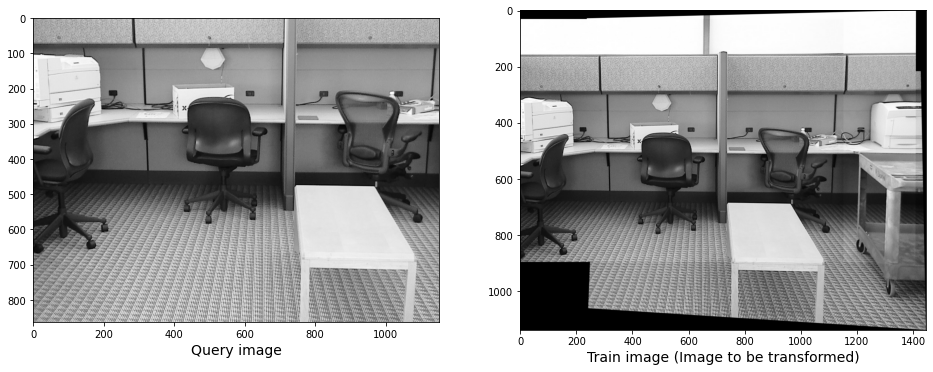

In [1187]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
# trainImg = imageio.imread('../Input/yard-1_50.jpg')
trainImg = imageio.imread('../finalProject/office_T12_3.jpg')

trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('../Input/Input/office/office-4.jpg')


# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [1188]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)


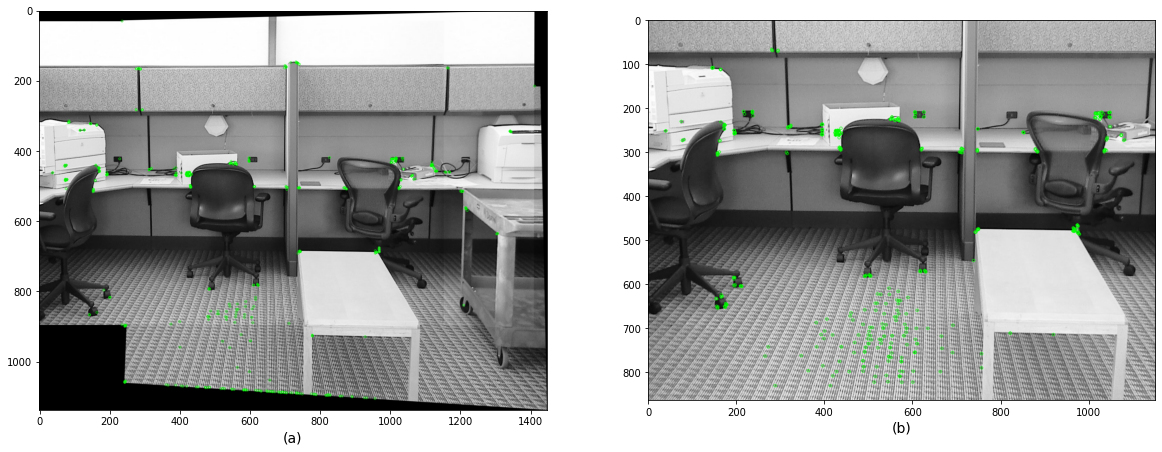

In [1189]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Using: knn feature matcher
Raw matches (knn): 500


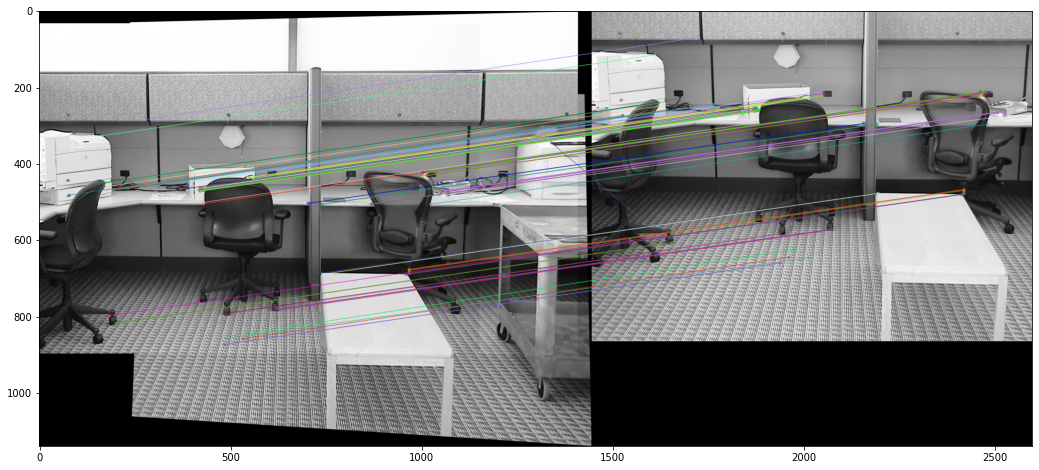

In [1190]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
plt.imshow(img3)
plt.show()

In [1191]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=20)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.03616825e+00  3.26191959e-02 -1.37674884e+01]
 [ 3.41481310e-04  1.05372104e+00 -2.27198245e+02]
 [-6.02561171e-07  5.82051341e-05  1.00000000e+00]]


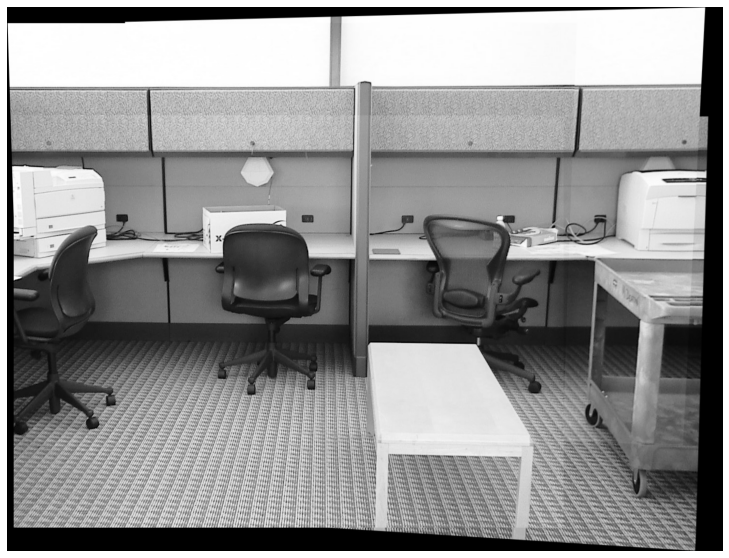

In [1192]:
# Apply panorama correction

h1, w1 = queryImg.shape[:2]
h2, w2 = trainImg.shape[:2]
pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
pts2_ = cv2.perspectiveTransform(pts2, H)
pts = np.concatenate((pts1, pts2_), axis=0)
[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

result = cv2.warpPerspective(trainImg, Ht.dot(H), (xmax - xmin, (ymax - ymin)))
result[t[1]:h1 + t[1], t[0]:w1 + t[0]] = queryImg



plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

1140


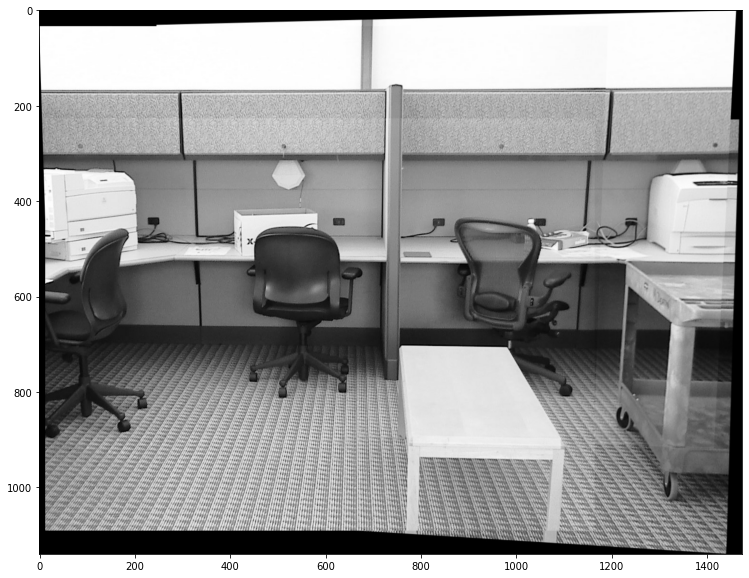

In [1193]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]
result = result[:,:]
# show the cropped image
print(result.shape[0])
plt.figure(figsize=(20,10))
plt.imshow(result)

In [1194]:
cv2.imwrite("office_T.jpg",cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

True

In [1237]:
from SSIM_PIL import compare_ssim
from PIL import Image
from skimage.measure import compare_ssim

# image1 = Image.open("../finalProject/office_T.jpg")
# image2 = Image.open("../Reference/office_Ref.jpg")
image1 = cv2.imread("../finalProject/Tower-T4.jpg",0)
print(image1.shape)

image2 = cv2.imread("../Reference/Tower_Ref.jpg",0)
print(image2.shape)

image2 = cv2.resize(image2,(image1.shape[1],image1.shape[0]))
print(image1.shape)

(score, diff) = compare_ssim(image1, image2, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

(995, 1948)
(796, 1610)
(995, 1948)


<ipython-input-1237-a0fef25e45a9>:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(image1, image2, full=True)


SSIM: 0.35461593136137337
